Link to the Kaggle challenge: https://www.kaggle.com/c/dog-breed-identification/overview
The data can be downloaded from the data page of the challenge.

This kernel is based on the pedagogical post 
https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
by Dipanjan Sarkar.

In [1]:
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

**Preliminary exploration of data**

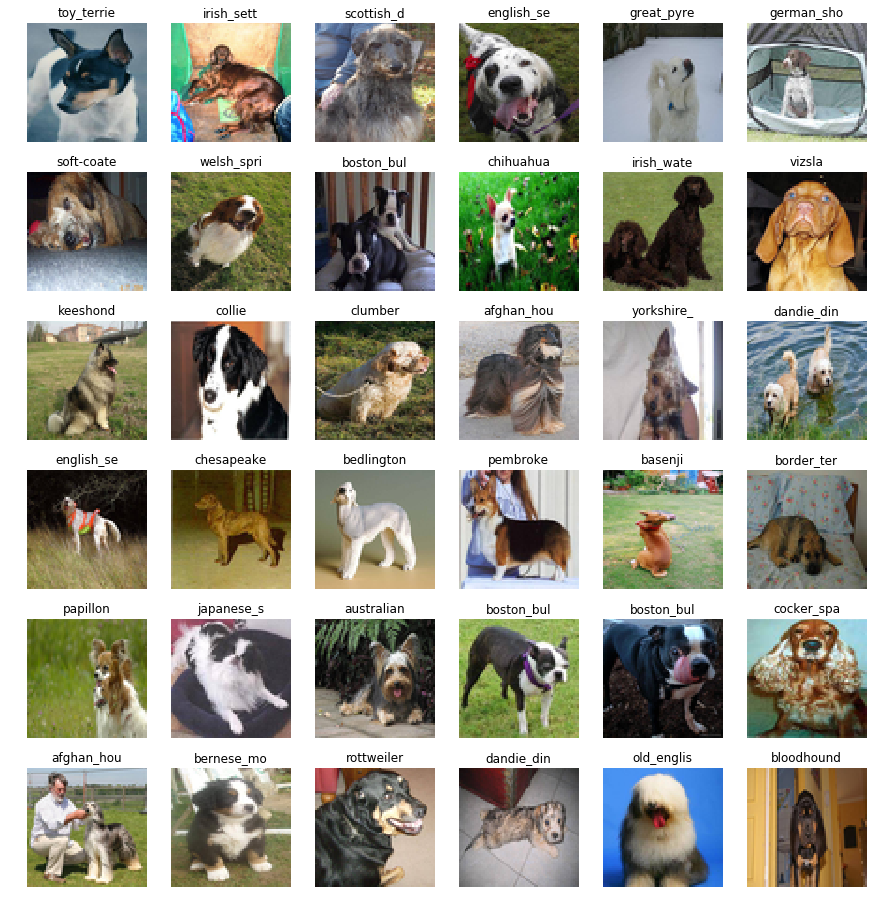

In [2]:
DATASET_PATH = 'dog-breed-identification/train/'
LABEL_PATH = 'dog-breed-identification/labels.csv'

# This function prepares a random batch from the dataset
def load_batch(dataset_df, batch_size = 25):
    batch_df = dataset_df.loc[np.random.permutation(np.arange(0,len(dataset_df)))[:batch_size],:]
    return batch_df
    
# This function plots sample images in specified size and in defined grid
def plot_batch(images_df, grid_width, grid_height, im_scale_x, im_scale_y):
    f, ax = plt.subplots(grid_width, grid_height)
    f.set_size_inches(12, 12)
    
    img_idx = 0
    for i in range(0, grid_width):
        for j in range(0, grid_height):
            ax[i][j].axis('off')
            ax[i][j].set_title(images_df.iloc[img_idx]['breed'][:10])
            ax[i][j].imshow(np.array(Image.fromarray(plt.imread(DATASET_PATH + images_df.iloc[img_idx]['id']+'.jpg'))
                                     .resize((im_scale_x,im_scale_y), resample=PIL.Image.LANCZOS)))
            img_idx += 1
            
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)

# load dataset and visualize sample data
dataset_df = pd.read_csv(LABEL_PATH)
batch_df = load_batch(dataset_df, batch_size=36)
plot_batch(batch_df, grid_width=6, grid_height=6,
im_scale_x=64, im_scale_y=64)

In [3]:
data_labels = pd.read_csv(LABEL_PATH)
target_labels = data_labels['breed']
print(len(set(target_labels)))
data_labels.head()

120


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


**Adding the image paths to the dataframes**

In [4]:
train_folder = 'dog-breed-identification/train/'
data_labels['image_path'] = data_labels.apply(lambda row: (train_folder + row["id"] + ".jpg" ), 
                                              axis=1)
data_labels.head()

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,dog-breed-identification/train/000bec180eb18c7...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,dog-breed-identification/train/001513dfcb2ffaf...
2,001cdf01b096e06d78e9e5112d419397,pekinese,dog-breed-identification/train/001cdf01b096e06...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,dog-breed-identification/train/00214f311d5d224...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,dog-breed-identification/train/0021f9ceb3235ef...


**Train-Val-Test splitting**

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img

# load dataset
train_data = np.array([img_to_array(load_img(img, target_size=(299, 299)))
                           for img in data_labels['image_path'].values.tolist()
                      ]).astype('float32')

# create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(train_data, target_labels, 
                                                    test_size=0.3, 
                                                    stratify=np.array(target_labels), 
                                                    random_state=42)

# create train and validation datasets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

Using TensorFlow backend.


In [6]:
print('Initial Dataset Size:', train_data.shape)
print('Initial Train and Test Datasets Size:', x_train.shape, x_test.shape)
print('Train and Validation Datasets Size:', x_train.shape, x_val.shape)
print('Train, Test and Validation Datasets Size:', x_train.shape, x_test.shape, x_val.shape)

Initial Dataset Size: (10222, 299, 299, 3)
Initial Train and Test Datasets Size: (6081, 299, 299, 3) (3067, 299, 299, 3)
Train and Validation Datasets Size: (6081, 299, 299, 3) (1074, 299, 299, 3)
Train, Test and Validation Datasets Size: (6081, 299, 299, 3) (3067, 299, 299, 3) (1074, 299, 299, 3)


**Creating one-hot-encoded labels**

In [7]:
y_train_ohe = pd.get_dummies(y_train.reset_index(drop=True)).as_matrix()
y_val_ohe = pd.get_dummies(y_val.reset_index(drop=True)).as_matrix()
y_test_ohe = pd.get_dummies(y_test.reset_index(drop=True)).as_matrix()

y_train_ohe.shape, y_test_ohe.shape, y_val_ohe.shape

((6081, 120), (3067, 120), (1074, 120))

In [ ]:
y_test_ohe[:5]

**Image augmentation: defining the generators**

In [8]:
from keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 32

# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle=False, 
                                     batch_size=BATCH_SIZE, seed=1)
                                     
# Create validation generator
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val_ohe, shuffle=False, 
batch_size=BATCH_SIZE, seed=1) 

### Transfer learning with Google's Inception V3 Model

**Model architecture**

In [9]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(299, 299, 3))
                             
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
total_classes = y_train_ohe.shape[1]
predictions = Dense(total_classes, activation='softmax')(out)

model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

**Training the model**

In [10]:
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=11, verbose=1)

Epoch 1/11
190/190 [==============================] - 1797s 9s/step - loss: 4.1417 - acc: 0.2202 - val_loss: 2.6360 - val_acc: 0.5663
Epoch 2/11
190/190 [==============================] - 1765s 9s/step - loss: 2.2213 - acc: 0.5599 - val_loss: 1.0998 - val_acc: 0.7399
Epoch 3/11
190/190 [==============================] - 1790s 9s/step - loss: 1.4245 - acc: 0.6628 - val_loss: 0.8457 - val_acc: 0.7726
Epoch 4/11
190/190 [==============================] - 1996s 11s/step - loss: 1.1360 - acc: 0.7017 - val_loss: 0.6910 - val_acc: 0.7946
Epoch 5/11
190/190 [==============================] - 2594s 14s/step - loss: 1.0170 - acc: 0.7290 - val_loss: 0.6614 - val_acc: 0.8081
Epoch 6/11
190/190 [==============================] - 2282s 12s/step - loss: 0.9507 - acc: 0.7390 - val_loss: 0.7133 - val_acc: 0.7985
Epoch 7/11
190/190 [==============================] - 1766s 9s/step - loss: 0.8592 - acc: 0.7607 - val_loss: 0.6591 - val_acc: 0.7869
Epoch 8/11
190/190 [==============================] - 1835s

In [11]:
model.save('NN TF-InceptionV3 model.h5')

In [12]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
#hist_json_file = 'history.json' 
#with open(hist_json_file, mode='w') as f:
#    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [22]:
def plot_learning_curves(history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle('NN with TF from Inception V3 Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    n_epoch = len(history.history['acc'])
    epoch_list = list(range(1,n_epoch + 1))
    ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, n_epoch+1, 3))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, n_epoch+1, 3))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

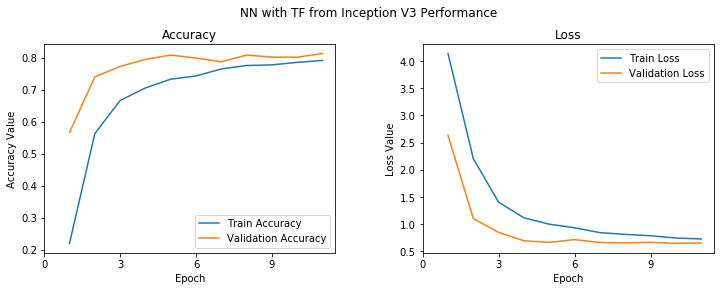

In [23]:
plot_learning_curves(history)

### Predictions

In [31]:
# scaling test features
x_test /= 255.

test_predictions = model.predict(x_test)

In [32]:
labels_ohe_names = pd.get_dummies(target_labels, sparse=True)
predictions_proba = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
predictions = list(predictions_proba.idxmax(axis=1))
test_labels = list(y_test)

In [38]:
predictions[:5], test_labels[:5]

(['rhodesian_ridgeback',
  'italian_greyhound',
  'appenzeller',
  'cocker_spaniel',
  'sealyham_terrier'],
 ['whippet',
  'italian_greyhound',
  'appenzeller',
  'cocker_spaniel',
  'sealyham_terrier'])

In [40]:
# evaluate model performance
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_labels,predictions)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.8728399087055755


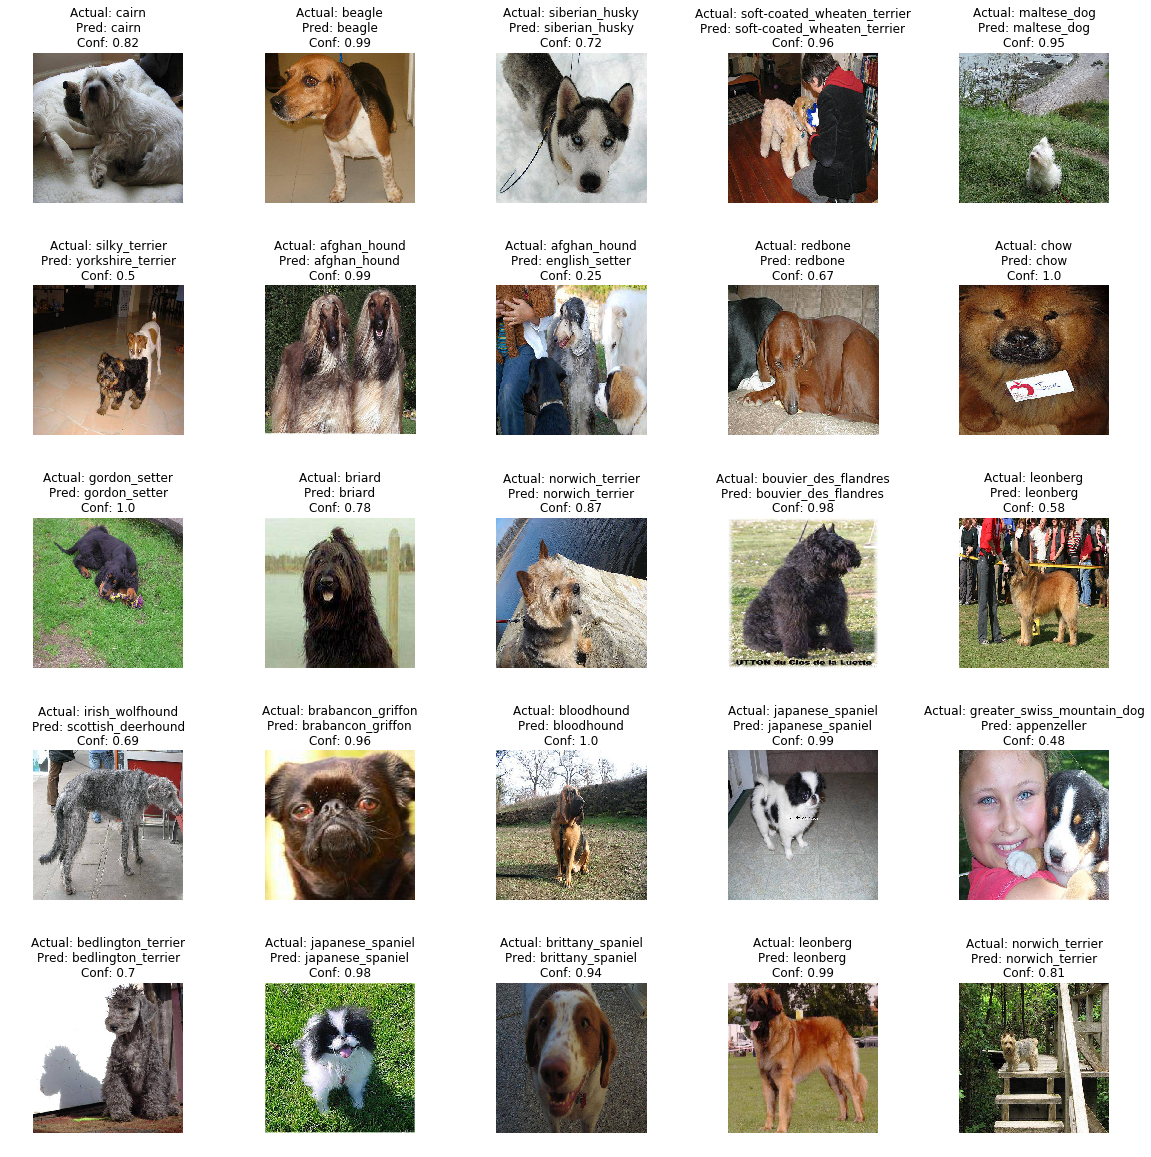

In [41]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)
batch_size = 25
dataset = x_test

labels_ohe_names = pd.get_dummies(target_labels, sparse=True)
labels_ohe = np.asarray(labels_ohe_names)
label_dict = dict(enumerate(labels_ohe_names.columns.values))
model_input_shape = (1,)+model.get_input_shape_at(0)[1:]
random_batch_indx = np.random.permutation(np.arange(0,len(dataset)))[:batch_size]

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual_label = np.array(y_test)[random_batch_indx[img_idx]]
        prediction = model.predict(dataset[random_batch_indx[img_idx]].reshape(model_input_shape))[0]
        label_idx = np.argmax(prediction)
        predicted_label = label_dict.get(label_idx)
        conf = round(prediction[label_idx], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+actual_label+'\nPred: '+predicted_label + '\nConf: ' +str(conf))
        ax[i][j].imshow(dataset[random_batch_indx[img_idx]])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55) 

### Predictions on the Kaggle Test set and submission

In [43]:
SUBMISSION_PATH = 'dog-breed-identification/sample_submission.csv'
data_submission = pd.read_csv(SUBMISSION_PATH)
data_submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [44]:
igm_path = data_submission.apply(lambda row: ('dog-breed-identification/test/' + row["id"] + ".jpg" ), axis=1)

In [46]:
igm_path[:5]

0    dog-breed-identification/test/000621fb3cbb32d8...
1    dog-breed-identification/test/00102ee9d8eb9081...
2    dog-breed-identification/test/0012a730dfa437f5...
3    dog-breed-identification/test/001510bc8570bbee...
4    dog-breed-identification/test/001a5f3114548acd...
dtype: object

In [47]:
len(data_submission), len(igm_path)

(10357, 10357)

In [48]:
submission_data = np.array([img_to_array(load_img(img, target_size=(299, 299)))
                           for img in igm_path.values.tolist() ]).astype('float32')

In [49]:
x_sub = submission_data/255.

In [50]:
predict_proba_kaggle = model.predict(x_sub)

In [51]:
predict_proba_kaggle[:5]

array([[4.94673768e-05, 1.50218184e-05, 1.45662079e-06, 5.21244317e-07,
        4.09053882e-06, 3.93859636e-06, 7.77558114e-07, 1.41629125e-05,
        3.04393507e-06, 9.35596381e-06, 1.85518832e-06, 4.24999189e-06,
        7.88002126e-06, 1.40046596e-03, 8.43461294e-06, 5.73302350e-06,
        5.39791017e-06, 9.07500123e-07, 1.99287661e-05, 1.29350345e-04,
        5.08981066e-06, 5.52121946e-06, 1.55865764e-05, 7.58411772e-07,
        1.35827486e-05, 5.17122373e-07, 9.91897195e-08, 1.01128762e-06,
        1.83201576e-06, 2.38420005e-04, 4.56253792e-06, 1.78532664e-05,
        2.79586384e-05, 1.65431429e-05, 1.98736393e-06, 5.44554587e-06,
        6.85083648e-07, 3.66665631e-07, 1.72896694e-06, 4.41876364e-05,
        4.86587396e-06, 3.32365676e-06, 1.34873453e-05, 2.31552385e-05,
        5.75086119e-07, 4.07089738e-06, 1.35405401e-06, 1.74794832e-06,
        9.22031234e-07, 5.80592086e-06, 5.40979408e-06, 4.80718609e-06,
        2.68136455e-06, 7.91372659e-05, 3.64773700e-06, 8.244130

In [111]:
prediction_df = pd.DataFrame(predict_proba_kaggle, columns=labels_ohe_names.columns)

In [112]:
id_df = pd.DataFrame(data_submission.id, columns=['id'])
submission_df = pd.concat([id_df, prediction_df], axis=1)

In [113]:
submission_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.000049,0.000015,0.000001,5.212443e-07,0.000004,0.000004,7.775581e-07,0.000014,0.000003,...,0.000007,0.000010,0.000024,0.000028,0.000002,7.718810e-07,0.000002,0.000001,0.000015,0.000005
1,00102ee9d8eb90812350685311fe5890,0.000003,0.000013,0.000002,4.368185e-05,0.000007,0.000070,4.399517e-06,0.000104,0.000011,...,0.000047,0.000004,0.000028,0.000016,0.000018,7.493687e-06,0.000579,0.000030,0.000096,0.000012
2,0012a730dfa437f5f3613fb75efcd4ce,0.000002,0.001429,0.000046,4.960566e-06,0.000012,0.000008,3.730374e-06,0.000002,0.000033,...,0.000004,0.000015,0.000004,0.000290,0.000030,6.812555e-04,0.000013,0.000033,0.000024,0.000026
3,001510bc8570bbeee98c8d80c8a95ec1,0.001626,0.000021,0.000069,8.020404e-07,0.000227,0.000003,1.217529e-05,0.000004,0.000008,...,0.000044,0.000028,0.000050,0.000076,0.000005,5.175469e-07,0.000001,0.000009,0.000005,0.000008
4,001a5f3114548acdefa3d4da05474c2e,0.023849,0.000031,0.000074,9.308346e-07,0.000026,0.000005,1.954463e-05,0.000017,0.000008,...,0.000209,0.000410,0.000126,0.000164,0.000003,7.996725e-07,0.000022,0.000016,0.000027,0.000090


In [116]:
submission_df.to_csv('submission_kaggle.csv', index=False)